In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

c:\Users\MNIS\Anaconda3\envs\ModelBasedML38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Processing

In [2]:
scaler = StandardScaler()

In [3]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [4]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [5]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [6]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)

df_train_target = df_train[['Class']].sample(100)
df_train_target_index = df_train_target.index
df_train_features = df_features.iloc[df_train_target_index].to_numpy()
df_train_target = df_train_target.to_numpy()

df_features_new = df_features
df_features_new[['Class']] = df_train[['Class']]
# df_features_new

df_rest_features = df_features_new.drop(index = df_train_target_index).reset_index()
# df_rest_target = df_train_target.iloc[~df_train_target_index].reset_index()
df_rest_features = df_rest_features.drop(columns = {df_rest_features.columns[0]})
df_test_target = df_rest_features[['Class']].sample(100)
df_test_target_index = df_test_target.index

df_test_features = df_rest_features.iloc[df_test_target_index]
df_test_features = df_test_features.drop(columns={'Class'}).to_numpy()

df_test_target = df_test_target.to_numpy()

# df_rest_features

In [9]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
n_cat = 11 

### Ancestral Sampling 

In [10]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [ 0.66007553  0.55486211 -0.7015883   0.34931553  0.33330288  1.73944186
 -1.8234705  -1.14715359  0.36090858  1.06060521  0.42972262 -0.32335793
 -1.53265817  0.33710799]


In [11]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))
label_array

array([ 5.,  7., 10.,  1.,  1.,  8.,  9.,  7.,  2.,  3.,  7.,  9.,  9.,
        6.,  6.,  3.,  3.,  9.,  9.,  3.,  7.,  2.,  9.,  2.,  9.,  4.,
        7.,  9.,  3.,  9.,  0.,  6., 10.,  4.,  9.,  9.,  3.,  9.,  6.,
        2.,  2.,  3.,  2.,  9.,  7.,  9.,  6.,  3.,  9.,  7.,  5.,  5.,
        7.,  9.,  7.,  3.,  3.,  7.,  1., 10.,  8.,  3.,  2.,  8.,  0.,
        9.,  1.,  3.,  5.,  7.,  7.,  8.,  6.,  5.,  7.,  2.,  0.,  1.,
        0.,  1., 10.,  0.,  0.,  5.,  7.,  3.,  2., 10.,  3.,  5.,  7.,
        8.,  2.,  7.,  3.,  9.,  2.,  4.,  6.,  7.])

In [12]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({5.0: 7,
         7.0: 17,
         10.0: 5,
         1.0: 6,
         8.0: 5,
         9.0: 18,
         2.0: 11,
         3.0: 15,
         6.0: 7,
         4.0: 3,
         0.0: 6})

In [13]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.07


### Model implementation with Pyro

In [14]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [15]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Model training 

In [16]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1531.4
[1000] ELBO: 829.5
[2000] ELBO: 543.0
[3000] ELBO: 495.9
[4000] ELBO: 422.3
[5000] ELBO: 391.9
[6000] ELBO: 390.1
[7000] ELBO: 374.2
[8000] ELBO: 369.9
[9000] ELBO: 353.1
[10000] ELBO: 360.4
[11000] ELBO: 340.6
[12000] ELBO: 355.0
[13000] ELBO: 348.8
[14000] ELBO: 342.0
[15000] ELBO: 372.5
[16000] ELBO: 353.5
[17000] ELBO: 330.9
[18000] ELBO: 352.5
[19000] ELBO: 355.7


In [18]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train)

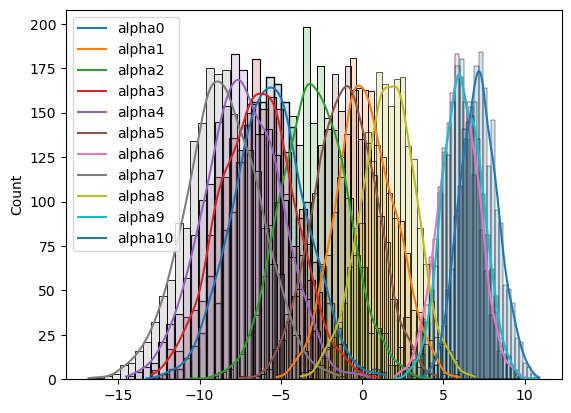

In [19]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

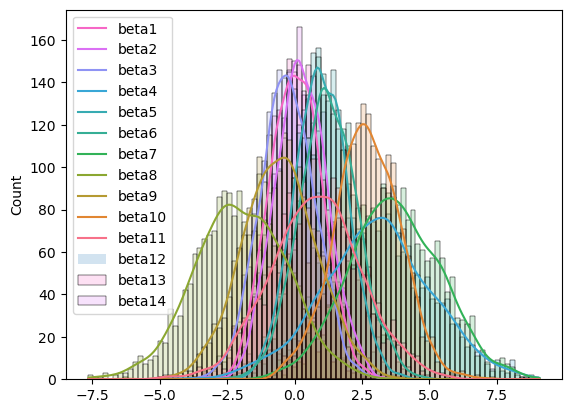

In [20]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [21]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

### Inference and computation of accuracy on the train dataset 

In [22]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_train_pred[n,:][0])

n, p and y  0 [2.37560497e-16 5.67173729e-05 6.76023129e-05 2.15688341e-14
 7.24826609e-13 2.59006855e-01 2.28817458e-04 3.45976274e-10
 7.25281222e-01 2.53401267e-08 1.53587606e-02] 8.0
n, p and y  1 [3.47356810e-03 1.62750682e-09 3.87481142e-04 5.34632354e-06
 1.72164609e-02 9.78877580e-01 5.63103730e-09 1.12153098e-06
 1.34494242e-07 3.82888414e-05 1.15092353e-08] 5.0
n, p and y  2 [6.17298855e-10 3.83394821e-10 9.98723972e-01 5.10007964e-04
 2.32484163e-09 7.58431927e-04 8.98863163e-09 3.23640288e-10
 1.58292272e-06 5.07932831e-06 9.13087797e-07] 2.0
n, p and y  3 [2.32443292e-13 2.09079657e-25 5.52962626e-13 1.00000000e+00
 1.36041547e-15 8.94210514e-12 3.95585584e-21 5.66526111e-19
 9.25631773e-18 1.21888405e-11 4.35250283e-18] 3.0
n, p and y  4 [1.44360573e-09 1.15556765e-04 1.09917889e-05 5.56607434e-08
 8.71113546e-08 2.57482471e-05 1.03087466e-06 7.52649885e-11
 9.98843287e-01 6.15735972e-06 9.97083666e-04] 8.0
n, p and y  5 [2.80392181e-06 1.69413276e-03 9.95037642e-01 4.439

In [23]:
y_train_pred = y_train_pred[:,0]

In [24]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.45


### Inference and computation of accuracy on the test dataset 

In [25]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_test_pred[n,:])

n, p and y  0 [2.98665798e-04 4.01151586e-07 1.21013450e-06 3.80567830e-04
 1.53761273e-06 2.18382679e-06 5.82837683e-07 5.31373008e-10
 9.99260890e-01 4.16574287e-05 1.23024933e-05] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  1 [9.95706479e-01 4.06764897e-03 3.94626642e-07 3.38257053e-07
 6.82498978e-07 6.16968968e-08 7.81009339e-07 1.14699093e-08
 2.22264841e-04 8.56792232e-07 4.81025011e-07] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
n, p and y  2 [6.60603736e-01 5.13011943e-03 2.27919779e-03 1.39035947e-05
 4.71199256e-04 8.78171108e-06 8.20219036e-03 1.00822067e-05
 3.12151494e-01 2.47273734e-04 1.08820214e-02] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
n, p and y  3 [4.11881684e-02 1.08882446e-02 4.38317662e-02 1.55001318e-05
 2.80776388e-01 2.22325746e-03 5.15518986e-04 6.48939700e-08
 6.10640777e-01 3.54387524e-04 9.56592763e-03] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  4 [3.44240561e-08 1.30646853e-04 3.70353339e-04 2.44007968e-03
 3.49970958e-04 9.89924049e-01 5.76682659e-04 2.98246

In [26]:
y_test_pred = y_test_pred[:,0]

In [27]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.18



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 

TODO

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Consider different distributions for priors
* Train model on more data - currently 100 
* Extend it with FFNN 
* Feature engineer name and album name and retrain logistic regression model using these attributes